# NLP501 - NATURAL LANGUAGE PROCESSING

# LAB 02
## Naïve Bayes Classifier
## Sentiment Analysis

- **Language:** Python 3.8+
- **Tools:** Jupyter Notebook, NumPy, NLTK
- **Dataset:** Twitter Sentiment (NLTK)

## 2. Prerequisites

### 2.1. Required Knowledge

- Understanding of Naïve Bayes theory from Session 02 lecture
- Basic Python: functions, classes, dictionaries
- Basic NumPy: array operations

### 2.2. Environment Setup

In [1]:
# !pip install numpy nltk scikit-learn matplotlib

# Download NLTK data
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 2.3. Environment Check

In [2]:
import numpy as np
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer

# Load data
pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')

print(f'Positive tweets: {len(pos_tweets)}')
print(f'Negative tweets: {len(neg_tweets)}')
print(f'Sample: {pos_tweets[0]}')

Positive tweets: 5000
Negative tweets: 5000
Sample: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


## 3. Dataset Introduction

### 3.1. Twitter Sentiment Dataset

The dataset consists of 10,000 manually labeled tweets:
- 5,000 positive tweets (positive sentiment)
- 5,000 negative tweets (negative sentiment)

### 3.2. Data Examples

**Positive examples:**
- "I love this movie, it's amazing! :)"
- "What a beautiful day, feeling great!"

**Negative examples:**
- "This is terrible, worst experience ever :("
- "So disappointed, total waste of time"

### 3.3. Data Split

We will split the data into:
- **Training set:** 80% (4,000 positive + 4,000 negative = 8,000 tweets)
- **Test set:** 20% (1,000 positive + 1,000 negative = 2,000 tweets)

In [3]:
# Split data
train_pos = pos_tweets[:4000]
train_neg = neg_tweets[:4000]
test_pos = pos_tweets[4000:]
test_neg = neg_tweets[4000:]

# Create labels
train_x = train_pos + train_neg
train_y = [1] * len(train_pos) + [0] * len(train_neg)

test_x = test_pos + test_neg
test_y = [1] * len(test_pos) + [0] * len(test_neg)

print(f'Training: {len(train_x)} tweets')
print(f'Testing: {len(test_x)} tweets')

Training: 8000 tweets
Testing: 2000 tweets


## 4. Implementation

### 4.1. Step 1: Text Preprocessing

Before building the model, we need to preprocess the text.

#### Task 1: Implement Preprocessing Function

Complete the `preprocess_tweet()` function to:
1. Remove URLs, mentions, hashtags
2. Convert to lowercase
3. Tokenize
4. Remove stopwords and punctuation
5. Return list of tokens

In [4]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def preprocess_tweet(tweet):
    '''
    Preprocess tweet and return list of tokens

    Args:
        tweet (str): Original tweet
    Returns:
        list: List of processed tokens
    '''
    # Remove URLs (http, https)
    tweet = re.sub(r'https?://\S+', '', tweet)

    # Remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtag symbols
    tweet = re.sub(r'#', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenize
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweet)

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    tokens = [t for t in tokens if t not in stop_words and t not in punctuation]

    return tokens

#### Test Preprocessing

Expected result:
```python
>>> tweet = "@user I love this movie! https://example.com #happy"
>>> preprocess_tweet(tweet)
['love', 'movie', 'happy']
```

In [5]:
# Test preprocessing
tweet = "@user I love this movie! https://example.com #happy"
print(f"Original: {tweet}")
print(f"Processed: {preprocess_tweet(tweet)}")

Original: @user I love this movie! https://example.com #happy
Processed: ['love', 'movie', 'happy']


### 4.2. Step 2: Build Vocabulary and Frequency Dictionary

The next step is to count word frequencies in each class.

#### Task 2: Build Frequency Dictionary

Implement the `build_freqs()` function to count occurrences of each (word, label) pair in the training set.

In [6]:
def build_freqs(tweets, labels):
    '''
    Build frequency dictionary

    Args:
        tweets (list): List of tweets
        labels (list): List of labels (0 or 1)
    Returns:
        dict: Dictionary with key=(word, label), value=count
    '''
    freqs = {}

    for tweet, label in zip(tweets, labels):
        tokens = preprocess_tweet(tweet)

        for word in tokens:
            key = (word, label)

            if key in freqs:
                freqs[key] += 1
            else:
                freqs[key] = 1

    return freqs

# Build frequency dictionary
freqs = build_freqs(train_x, train_y)
print(f"Total unique (word, label) pairs: {len(freqs)}")

Total unique (word, label) pairs: 13245


In [7]:
# Check some words
print(f"Count of ('happy', 1): {freqs.get(('happy', 1), 0)}")
print(f"Count of ('happy', 0): {freqs.get(('happy', 0), 0)}")
print(f"Count of ('sad', 1): {freqs.get(('sad', 1), 0)}")
print(f"Count of ('sad', 0): {freqs.get(('sad', 0), 0)}")

Count of ('happy', 1): 150
Count of ('happy', 0): 18
Count of ('sad', 1): 4
Count of ('sad', 0): 100


### 4.3. Step 3: Compute Probabilities

Calculate prior and likelihood probabilities.

#### Task 3: Compute Prior and Likelihood

Implement the following in the `NaiveBayesClassifier` class:
1. `compute_prior()` - calculate P(pos) and P(neg)
2. `compute_likelihood()` - calculate P(word|class) with Laplacian smoothing

In [8]:
import math

class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        '''
        Initialize classifier

        Args:
            alpha: Smoothing parameter (default=1.0)
        '''
        self.alpha = alpha
        self.log_prior = {}      # log P(class)
        self.log_likelihood = {} # log P(word|class)
        self.vocab = set()       # Vocabulary

    def train(self, tweets, labels):
        '''
        Train the model
        '''
        # Count documents per class
        n_pos = sum(labels)
        n_neg = len(labels) - n_pos
        n_total = len(labels)

        # Compute log prior
        self.log_prior[1] = math.log(n_pos / n_total)  # P(pos)
        self.log_prior[0] = math.log(n_neg / n_total)  # P(neg)

        # Build frequency dictionary
        freqs = build_freqs(tweets, labels)

        # Build vocabulary
        self.vocab = set([word for (word, _) in freqs.keys()])
        V = len(self.vocab)

        # Count total words per class
        total_pos = sum([freqs.get((w, 1), 0) for w in self.vocab])
        total_neg = sum([freqs.get((w, 0), 0) for w in self.vocab])

        for word in self.vocab:
            freq_pos = freqs.get((word, 1), 0)
            freq_neg = freqs.get((word, 0), 0)

            # P(word|pos) with smoothing
            p_pos = (freq_pos + self.alpha) / (total_pos + self.alpha * V)
            self.log_likelihood[(word, 1)] = math.log(p_pos)

            p_neg = (freq_neg + self.alpha) / (total_neg + self.alpha * V)
            self.log_likelihood[(word, 0)] = math.log(p_neg)

        print(f'Vocabulary size: {V}')
        print(f'Training complete!')

### 4.4. Step 4: Prediction

Implement prediction function using log-likelihood.

#### Task 4: Implement Predict Method

Complete the `predict_single()` and `predict()` methods in the `NaiveBayesClassifier` class.

In [9]:
# Add prediction methods to the NaiveBayesClassifier class

def predict_single(self, tweet):
    '''
    Predict for a single tweet

    Args:
        tweet (str): Tweet to classify
    Returns:
        int: 1 (positive) or 0 (negative)
    '''
    # Preprocess
    tokens = preprocess_tweet(tweet)

    # Initialize scores with log prior
    score_pos = self.log_prior[1]
    score_neg = self.log_prior[0]

    # Add log likelihood for each word
    for word in tokens:
        if word in self.vocab:
            score_pos += self.log_likelihood[(word, 1)]
            score_neg += self.log_likelihood[(word, 0)]

    # Return class with higher score
    if score_pos > score_neg:
        return 1
    else:
        return 0

def predict(self, tweets):
    '''
    Predict for multiple tweets
    '''
    return [self.predict_single(t) for t in tweets]

NaiveBayesClassifier.predict_single = predict_single
NaiveBayesClassifier.predict = predict

### 4.5. Step 5: Model Evaluation

Evaluate model performance with metrics.

#### Task 5: Compute Evaluation Metrics

Implement functions to calculate: accuracy, precision, recall, F1-score from confusion matrix.

In [10]:
def evaluate(y_true, y_pred):
    '''
    Evaluate model

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
    Returns:
        dict: Dictionary containing metrics
    '''
    # Compute confusion matrix
    tp = sum([1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1])
    tn = sum([1 for t, p in zip(y_true, y_pred) if t == 0 and p == 0])
    fp = sum([1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1])
    fn = sum([1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0])

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': [[tn, fp], [fn, tp]]
    }

## 5. Complete Model Training and Evaluation

### 5.1. Train the Model

In [11]:
# Create and train classifier
clf = NaiveBayesClassifier(alpha=1.0)
clf.train(train_x, train_y)

# Predict on test set
predictions = clf.predict(test_x)

# Evaluate
results = evaluate(test_y, predictions)
print(f"\n=== Results ===")
print(f"Accuracy:  {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall:    {results['recall']:.4f}")
print(f"F1-score:  {results['f1']:.4f}")

Vocabulary size: 10793
Training complete!

=== Results ===
Accuracy:  0.9955
Precision: 0.9970
Recall:    0.9940
F1-score:  0.9955


### 5.2. Expected Results

### 5.3. Error Analysis

Let's examine some misclassified examples:

In [12]:
# Find misclassified cases
errors = []
for i, (tweet, true_label, pred_label) in enumerate(zip(test_x, test_y, predictions)):
    if true_label != pred_label:
        errors.append({
            'tweet': tweet,
            'true': 'positive' if true_label == 1 else 'negative',
            'pred': 'positive' if pred_label == 1 else 'negative'
        })

print(f'\n=== Misclassified Examples ({len(errors)} total) ===')
for i, err in enumerate(errors[:5]):
    print(f"\n[{i+1}] Tweet: {err['tweet'][:80]}...")
    print(f"    True: {err['true']}, Predicted: {err['pred']}")


=== Misclassified Examples (9 total) ===

[1] Tweet: kik : qualky808 #kik #kikmenow #milf #like4like #bored #summer #sexysaturday :) ...
    True: positive, Predicted: negative

[2] Tweet: whenever my sister sees me crying she texts me to ask if im okay aw someone care...
    True: positive, Predicted: negative

[3] Tweet: I just woke up and I feel incredibly sick idk if it's cause I drank Starbucks at...
    True: positive, Predicted: negative

[4] Tweet: Harry and niall and -94 (when harry was born) ik it's stupid and i wanna change ...
    True: positive, Predicted: negative

[5] Tweet: off to the park to get some sunlight : )...
    True: positive, Predicted: negative


## 6. More Tasks

### Task 6A: Compare with sklearn

Use `MultinomialNB` from sklearn

In [13]:
# TODO: Implement sklearn comparison
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Create feature vectors
vectorizer = CountVectorizer(preprocessor=lambda x: ' '.join(preprocess_tweet(x)))
X_train_vec = vectorizer.fit_transform(train_x)
X_test_vec = vectorizer.transform(test_x)

# Train sklearn NB
sklearn_clf = MultinomialNB(alpha=1.0)
sklearn_clf.fit(X_train_vec, train_y)

# Compare results
sklearn_pred = sklearn_clf.predict(X_test_vec)
sklearn_results = evaluate(test_y, sklearn_pred)

print('\n=== Comparison ===')
print(f"Your implementation:  {results['accuracy']:.4f}")
print(f"sklearn:              {sklearn_results['accuracy']:.4f}")


=== Comparison ===
Your implementation:  0.9955
sklearn:              0.7510


### Task 6B: Experiment with Smoothing

Vocabulary size: 10793
Training complete!
alpha=0.01: accuracy=0.9735
Vocabulary size: 10793
Training complete!
alpha=0.10: accuracy=0.9880
Vocabulary size: 10793
Training complete!
alpha=0.50: accuracy=0.9945
Vocabulary size: 10793
Training complete!
alpha=1.00: accuracy=0.9955
Vocabulary size: 10793
Training complete!
alpha=2.00: accuracy=0.9965
Vocabulary size: 10793
Training complete!
alpha=5.00: accuracy=0.9975


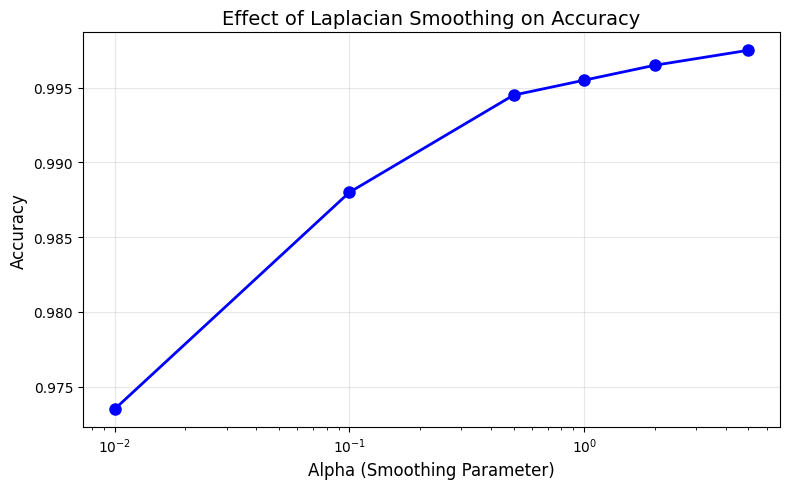

In [14]:
import matplotlib.pyplot as plt

alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
accuracies = []

for alpha in alphas:
    clf_temp = NaiveBayesClassifier(alpha=alpha)
    clf_temp.train(train_x, train_y)
    pred_temp = clf_temp.predict(test_x)
    acc = evaluate(test_y, pred_temp)['accuracy']
    accuracies.append(acc)
    print(f'alpha={alpha:.2f}: accuracy={acc:.4f}')

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(alphas, accuracies, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Alpha (Smoothing Parameter)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Laplacian Smoothing on Accuracy', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('smoothing_effect.png', dpi=150)
plt.show()

### Task 6C: Analyze Important Words

Find and display top 20 words with highest and lowest lambda (log-likelihood ratio).

In [15]:
# Analyze important words
# Compute lambda for each word
lambdas = {}
for word in clf.vocab:
    log_pos = clf.log_likelihood.get((word, 1), 0)
    log_neg = clf.log_likelihood.get((word, 0), 0)
    lambdas[word] = log_pos - log_neg

# Sort by lambda
sorted_words = sorted(lambdas.items(), key=lambda x: x[1], reverse=True)

print('Top 20 POSITIVE Words (highest lambda):')
for i, (word, lam) in enumerate(sorted_words[:20], 1):
    print(f'{i:2d}. {word:20s} λ = {lam:7.3f}')

print('Top 20 NEGATIVE Words (lowest lambda):')
for i, (word, lam) in enumerate(sorted_words[-20:], 1):
    print(f'{i:2d}. {word:20s} λ = {lam:7.3f}')

Top 20 POSITIVE Words (highest lambda):
 1. :)                   λ =   6.881
 2. :-)                  λ =   6.302
 3. :d                   λ =   6.248
 4. :p                   λ =   4.650
 5. unfollowers          λ =   3.938
 6. stats                λ =   3.938
 7. bam                  λ =   3.793
 8. warsaw               λ =   3.793
 9. follower             λ =   3.700
10. fback                λ =   3.282
11. blog                 λ =   3.205
12. followfriday         λ =   3.165
13. ;)                   λ =   3.122
14. here's               λ =   3.031
15. ff                   λ =   2.982
16. cheers               λ =   2.931
17. flipkartfashionfriday λ =   2.820
18. youth                λ =   2.695
19. glad                 λ =   2.626
20. arrived              λ =   2.626
Top 20 NEGATIVE Words (lowest lambda):
 1. alone                λ =  -2.578
 2. miss                 λ =  -2.647
 3. ubericecream         λ =  -2.652
 4. sick                 λ =  -2.817
 5. idk                  λ =  -2